# COMM2550 Spring 2023 
# **Does Light Affect Crime?**

## By: Annabel Sumardi and Michael Li 
---
## Asking questions on the presence of street lights and crime in the Philadelphia datasets 
- Looking into whether light affects amount of crime

### The dataset 
- Data is available on opendataphilly.org
    - *Street Light data*: https://opendataphilly.org/datasets/street-poles/ 
    - *Crime data*: https://opendataphilly.org/datasets/crime-incidents/
    - *Philly Police District data*: https://opendataphilly.org/datasets/police-districts/

---

- [Police District Metadata](https://metadata.phila.gov/#home/datasetdetails/5543866f20583086178c4f24/representationdetails/55438ab79b989a05172d0d5b/)
- [Crime Metadata](https://metadata.phila.gov/#home/datasetdetails/5543868920583086178c4f8e/representationdetails/570e7621c03327dc14f4b68d/)
- [Street Pole Metadata](https://metadata.phila.gov/#home/datasetdetails/555f8135f15fcb6c6ed4413a/representationdetails/5571b1c4e4fb1d91393c2183/)

---

- CSV Version: 
    - `../data/philly.csv`
    - `../data/philly.geojson`
    - `../data/Street_Poles.csv`
    - `../data/Street_Poles.geojson`
    - `../data/crime.csv`
    - `../data/philadelphia_sunset_2022.tsv`
    
---

* Related articles
    * https://urbanlabs.uchicago.edu/projects/crime-lights-study
    * https://popcenter.asu.edu/content/improving-street-lighting-reduce-crime-residential-areas-page-2 


## <font color="blue"> Setup </font> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely import wkt

import contextily as cx

import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/share/jupyter/venv/py3_comm318/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## <font color="blue"> Import Philly District Data </font> 

- Importing **Philly Police District** boundaries, including a function which will allow the district numbers to be illustrated graphically
- This data will be used to plot our street pole and crime data on a PPD district map visualization.
- We will use a GeoPandas `GeoDataFrame` in order to do geospatial analysis with the `geometry` column


In [2]:
# imported from 3_opendataphilly_shooting, from Prof. O'Donnell
def show_district_nums(r, fcol='black'):
    plt.text(r['centX'], 
           r['centY'], 
           r['DIST_NUM'], 
           horizontalalignment='center',
           verticalalignment='center', fontsize=8, color=fcol)

In [3]:
districts_gdf = gpd.read_file('../data/philly.geojson')

## <font color="blue"> Inspect the District Data </font> 

- Regard the following variables in the district data: `District Number`, `Location`, and `Geometry`
    - We will use these variables to help sort our data by location.

In [4]:
# update 4/22, changing district column for simpler use later on (data cleaning/bigfixing)
districts_gdf.rename(columns={'DISTRICT_': 'district'}, inplace=True)
districts_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry
0,343,None,69282.588463,16,None,16,None,16,39th St. & Lancaster Ave.,686-3160,SWPD,1.216700e+08,1.927226e+07,27575.079183,"POLYGON ((-75.19957 40.00912, -75.19799 40.008..."
1,344,None,33150.154961,17,None,17,None,17,20th St. & Federal St.,686-3170,SPD,5.786368e+07,9.154950e+06,13179.953350,"POLYGON ((-75.16599 39.94184, -75.16621 39.940..."
2,345,None,54403.930038,18,None,18,None,18,55th St. & Pine St.,686-3180,SWPD,9.881929e+07,1.564117e+07,21629.610687,"POLYGON ((-75.18466 39.94851, -75.18633 39.947..."


## <font color="blue"> Plot the District Data </font> 

- This graph will be the base for our following graphs, where we can split data by district number to look into certain districts if there are any interesting cases or regions.
- We are adding the district numbers in the center of each shape here. 

### <font color="blue"> Steps </font>
1. Join district data
2. Plot districts on the map of Philly
3. Use this graph as the base for our upcoming heatmaps, hexbins, etc. 

In [5]:
# Check the CRS (coordinate reference system) for data
# important to make sure all geo sources in the same CRS
# when you do joins 
districts_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

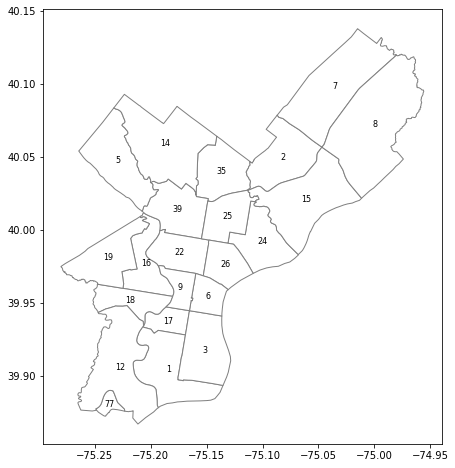

In [6]:
districts_gdf['centX']=districts_gdf['geometry'].centroid.x
districts_gdf['centY']=districts_gdf['geometry'].centroid.y
districts_gdf.plot(color='white', edgecolor='gray', figsize=(8,8))
districts_gdf.apply(show_district_nums, axis=1)
plt.show()

## <font color="green"> Import the Street Light Data </font> 

*Note the .. is to allow the data to read from the data folder, since it is stuck in the data_analysis folder without the extra piece of syntax

* **NOTE** - try and set data projects up so all file paths and references are **RELATIVE** so if it goes up to github or is distributed in someway there is nothing hard coded, e.g. NOT `/users/username/files/projects` or `C:\My Documents\Projects\`. It is amazing how often you see this on publicly distributed projects!
* Now, let's load the Street Poles data using `pandas` and `geopandas` 

In [7]:
street_poles_df = pd.read_csv('../data/Street_Poles.csv')
street_poles_gdf = gpd.read_file('../data/Street_Poles.geojson')

## <font color="green"> Inspect the Street Light Data </font> 

- Note the variables `x` and `y`, which will have to be converted to find which districts they lie in since that is not automatically provided

In [8]:
# fidget around with this more to figure out more nuances to street pole data (i.e. if illumination matters)
street_poles_df.head(3)

,X,Y,OBJECTID,OID,POLE_NUM,TYPE,NLUMIN,LUM_SIZE,HEIGHT,POLE_DATE,UP_DATE,OWNER,TAP_ID,BLOCK,PLATE
0,-75.066411,40.044774,1,0,1,WP,NaN,NaN,NaN,NaN,NaN,Streets,NaN,NaN,NaN
1,-75.061178,40.041861,2,0,3,TCB,NaN,NaN,NaN,NaN,NaN,Streets,NaN,NaN,NaN
2,-75.144451,40.008283,3,0,4,WP,NaN,NaN,NaN,NaN,NaN,Streets,NaN,NaN,NaN


### <font color="green"> What does our data inspection show us? </font>
    
* We can see the street pole data is separated into multiple columns, most importantly `geometry`, which we can use to graph where the light poles are in Philly
* The `.describe()` illustrates that the max pole ID is 195,680, meaning there is over 100K light poles in Philly. Because of the large amount, we will create a density plot to help illustrate where light poles are most present since just plotting points will cover most of the city without illustrating much nuance. 
    * Looking at the `count` value, the highest number of street poles is 195,680, so there's almost 200K street poles with inputted data in Philly.
* Another column of interest is the NLUMIN column, which displays the light lumin count. A higher lumin count correlates with a brighter light, so it would be good to note this when regarding how some street poles might be brighter than others. 
    - We look below to see how there are many different lumin counts, which means there is varying brightnesses of the poles. 
    - There appears to be mostly lumin counts of 1.0 or missing data, which hopefully implies general consistency so that if we do not account for the differences the data still comes to a similar conclusion.
* There also seems to be issues with the street pole date installation. The data is either missing or was not recorded in the first place. 

</div>

In [9]:
street_poles_gdf.head(3)

,OBJECTID,OID,POLE_NUM,TYPE,NLUMIN,LUM_SIZE,HEIGHT,POLE_DATE,UP_DATE,OWNER,TAP_ID,BLOCK,PLATE,geometry
0,1,0,1,WP,NaN,NaN,NaN,None,None,Streets,NaN,None,None,POINT (-75.06641 40.04477)
1,2,0,3,TCB,NaN,NaN,NaN,None,None,Streets,NaN,None,None,POINT (-75.06118 40.04186)
2,3,0,4,WP,NaN,NaN,NaN,None,None,Streets,NaN,None,None,POINT (-75.14445 40.00828)


In [10]:
street_poles_gdf.describe()

,OBJECTID,OID,POLE_NUM,NLUMIN,LUM_SIZE,HEIGHT,TAP_ID
count,195680.000000,195680.0,195680.000000,127250.000000,127250.000000,127250.000000,189306.000000
mean,97840.500000,0.0,413723.817943,1.139096,119.425713,23.201925,271003.571884
std,56488.094675,0.0,201181.932181,20.300365,62.158322,5.180471,253004.974118
min,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48920.750000,0.0,223944.750000,1.000000,100.000000,20.000000,0.000000
50%,97840.500000,0.0,415435.500000,1.000000,100.000000,25.000000,221839.000000
75%,146760.250000,0.0,600604.250000,1.000000,121.000000,25.000000,509248.750000
max,195680.000000,0.0,889111.000000,3614.000000,400.000000,45.000000,883426.000000


In [11]:
street_poles_gdf.dtypes

OBJECTID        int64
OID             int64
POLE_NUM        int64
TYPE           object
NLUMIN        float64
LUM_SIZE      float64
HEIGHT        float64
POLE_DATE      object
UP_DATE        object
OWNER          object
TAP_ID        float64
BLOCK          object
PLATE          object
geometry     geometry
dtype: object

In [12]:
street_poles_gdf['NLUMIN'].unique()
# varying brightness

array([      nan, 1.000e+00, 2.000e+00, 1.400e+01, 4.000e+00, 3.614e+03,
       3.200e+02, 1.380e+02, 0.000e+00])

In [13]:
# This can be treated as a categorical value
street_poles_gdf['NLUMIN'].value_counts(dropna=False)

1.0       124974
NaN        68430
2.0         2243
14.0          16
4.0            8
3614.0         4
320.0          2
0.0            2
138.0          1
Name: NLUMIN, dtype: int64

In [14]:
# Can look at it as proportions
street_poles_gdf['NLUMIN'].value_counts(dropna=False, normalize=True)*100


1.0       63.866517
NaN       34.970360
2.0        1.146259
14.0       0.008177
4.0        0.004088
3614.0     0.002044
320.0      0.001022
0.0        0.001022
138.0      0.000511
Name: NLUMIN, dtype: float64

### <font color="green"> Further Lumin Observations? </font>

* Almost 2/3 of lamps are 1 lumin and 1/3 have no value recorded - so no real variation in strength of light to work with here

In [15]:
# clean street_poles_gdf, redudundant cell, didn't end up using the cleaned one lol
simple_sp_gdf = street_poles_gdf[['OBJECTID', 'geometry']]
simple_sp_gdf.head(3)

,OBJECTID,geometry
0,1,POINT (-75.06641 40.04477)
1,2,POINT (-75.06118 40.04186)
2,3,POINT (-75.14445 40.00828)


## <font color="green"> Plot the Street Light Data </font> 

*Note that the street light data is extremely dense due to the amount of street lights in Philly. Thus, there is evidence of a couple blackout zones, but otherwise, most of the Philly map appears to be covered in data. The way we will deal with this is by heat mapping the data and other methods of showing street light density per district. 

## <font color="green"> Question: Is the geographical distribution of street lights denser in certain districts? </font>

### <font color="green"> Key columns </font>

* The police district field will be used for grouping to observe trends


### <font color="green"> Steps </font>

* Use the geometry data in the street pole data to map where the lights are present. 
* Try hexbin plots to illustrate where the lights are most dense. 
* An ideal plot type would allows us to plot the data onto a 2d map displaying the areas where street lights are most present in Philadelphian police districts expressed through different shading. 

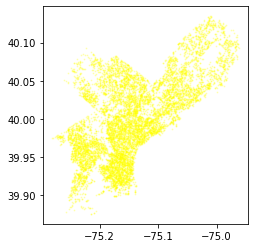

In [16]:
# too many points
# so don't try and plot all - instead take a sample
street_poles_gdf.sample(10_000).plot(markersize=1, alpha=0.2, color='yellow')
plt.show()


### <font color="green"> Some Hexbin Observations </font>
Below, the hexplot helps better illustrate density of the street lights in different regions. **Districts 6, 9, 17, 22, and 26** appear to have a dense amount of street lights compared to other areas in Philadelphia. 
- These areas correlate with where Center City is, covering down to Chinatown and up to Fishtown within its path. 
- This higher amount of street lights makes sense as these areas are downtown Philadelphia, where a dense amount of people either live there or visit there. Thus, safety would have to be a higher priority in these areas. 

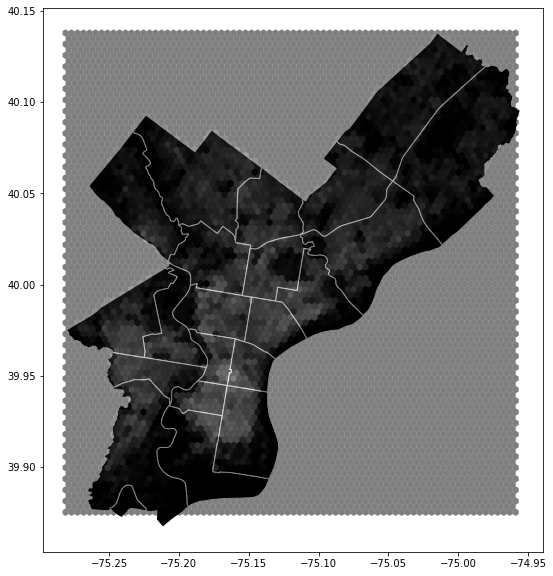

In [17]:
# trying to get a hexbin effect where low values are black (i.e. no/little light)
# and higher values go towards white overlay on basemap

fig,ax = plt.subplots(figsize=(10,10))
districts_gdf.plot(color='black', edgecolor='white', ax=ax)
ax.hexbin(x=street_poles_df['X'],
          y=street_poles_df['Y'],
          gridsize=75, edgecolor=None,
          alpha=0.5, cmap='binary_r')



* Not sure that this works so well... Because of the hexgrid...

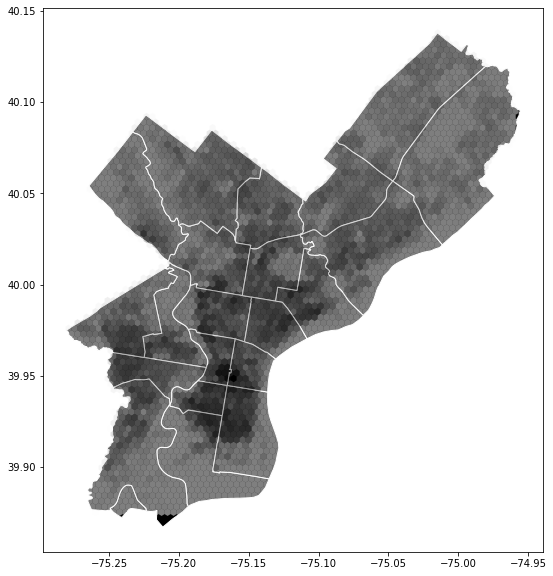

In [18]:
# trying to get a hexbin effect where low values are black (i.e. no/little light)
# and higher values go towards white overlay on basemap

fig,ax = plt.subplots(figsize=(10,10))
districts_gdf.plot(color='black', edgecolor='white', ax=ax)
ax.hexbin(x=street_poles_df['X'],
          y=street_poles_df['Y'],
          gridsize=75, edgecolor=None,
          alpha=0.5, cmap='binary')



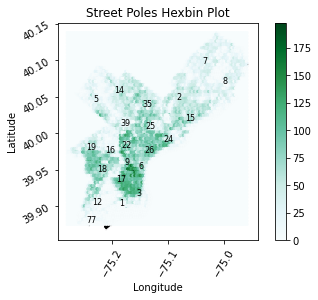

In [106]:
# Prof. O'Donnell suggested using a hexplot instead
# Much easier to use the df instead of GDF because extracting the x and y from geometry is annoying
base=districts_gdf.plot(color='black', edgecolor='white')
street_poles_df.plot.hexbin(x='X', y='Y', 
                            ax=base, 
                            column='OBJECTID', gridsize=100)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Street Poles Hexbin Plot')

districts_gdf.apply(show_district_nums, axis=1)

plt.xticks(rotation=60)
plt.yticks(rotation=30)
# Show the plot
plt.show()

### <font color="green"> Join data and inspect </font>
For the next graph, we will use an `sjoin` in order to map the street poles more clearly by district. Because the street pole data does not contain district ID, we will use the geometry to determine what district the street pole is in, which will allow us to map the street pole data by district. 
- We can see the pole count by district, which will be applied in the heatmap as a darker shade referring to a larget pole count. 
- We can check to see that the join worked by taking a sample table of the data and noting the columns from the 

In [20]:
# use an sjoin as suggested by Prof. O'Donnell
pole_district_gdf = gpd.sjoin(simple_sp_gdf, districts_gdf, how='left', op='within')
pole_district_gdf.head(3)


,OBJECTID_left,geometry,index_right,OBJECTID_right,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,centX,centY
0,1,POINT (-75.06641 40.04477),6.0,349.0,None,63587.369399,2.0,None,2.0,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,-75.081508,40.050009
1,2,POINT (-75.06118 40.04186),6.0,349.0,None,63587.369399,2.0,None,2.0,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,-75.081508,40.050009
2,3,POINT (-75.14445 40.00828),11.0,354.0,None,49749.035020,25.0,None,25.0,None,25,3700 Whittaker Ave,686-3250,EPD,1.179874e+08,1.870673e+07,19809.830073,-75.131465,40.009320


In [21]:
pole_counts = pole_district_gdf.groupby('district')['OBJECTID_left'].count().reset_index()
pole_counts.rename(columns={'OBJECTID_left': 'pole_count'}, inplace=True)
pole_counts

,district,pole_count
0,1.0,5137
1,2.0,9712
2,3.0,11447
3,5.0,6128
4,6.0,6542
5,7.0,10447
6,8.0,10414
7,9.0,6335
8,12.0,10248
9,14.0,14640


In [22]:
district_pole_gdf = districts_gdf.merge(pole_counts, on='district', how='right')


district_pole_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,pole_count
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,5137
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,9712
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,11447


### <font color="green"> Heatmap Steps </font>
- Plot the poles and police districts into a heatmap using the `.plot()` function 
With the now joined data, we can create a heatmap to best illustrate the amount of street poles per district. Here, we took note of the expressive principle: the darker green shading correlates with the more dense amount of street lights in a district. 
- Interestingly, district 15 appears to have the most street light compared to other districts. 
    - This could be attributed to an attempt to keep the district safe or one could also note the size of the district. When regarding the larger size of the district, it could make sense that it has the most street lights, as it needs to cover more area with light. The districts around Center City could have a higher density of lights per square foot of area, but because the districts are much smaller, the count of lights is smaller than that in the districts like 14 and 15. 

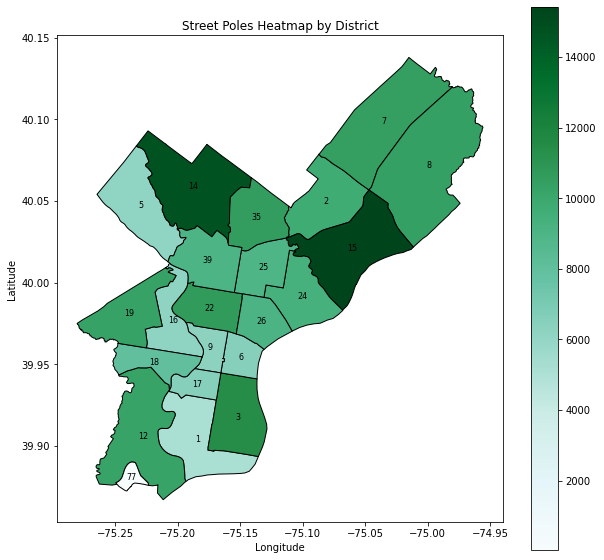

In [23]:
# plotting heatmap
fig, ax = plt.subplots(figsize=(10,10))
district_pole_gdf.plot(column='pole_count', cmap='BuGn', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Street Poles Heatmap by District')

dplot=districts_gdf.apply(show_district_nums, axis=1)


## <font color="red"> Time to Aggregate and Inspect the Crime + Street Light Data </font> 

INSTRUCTIONS for main analysis
1. Aggregate # of street poles per district using geodata
2. Plot for visual 
3. Heatmap it 
4. Aggregate crime (then split into granular types of crime) per district
    - Filter by nightfall, day vs night
5. Find correlation between variables (NOT NECESSARILY CAUSATION), and heatmap that

In [24]:
# ideas for more analysis
# differentiate the types of street poles, and find out more about them and how they pertain to other variables

### <font color="red">  Inspection Observations </font> 
In the following steps, we can read in the data and see that there are 18 columns, and 30,759 observations of crime from the 2022 dataset. 
- We chose 2022 because it was a full set of data 
- Key columns include `district` and `dispatch date`. We can use the district data to graph crime by police district, similar to the light map. We can also look at dispatch date to note how the CSV file we are looking at will reference 2022 data. 

In [25]:
crime_df = pd.read_csv('../data/crime.csv')

In [26]:
crime_df.shape

(30759, 18)

In [27]:
crime_df.columns

Index(['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist',
       'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour_',
       'dc_key', 'location_block', 'ucr_general', 'text_general_code',
       'point_x', 'point_y', 'lat', 'lng'],
      dtype='object')

In [28]:
crime_df.rename(columns={'dc_dist': 'district'}, inplace=True)
crime_df.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
0,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210204,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223360,12,1,2022-08-22 22:31:00+00,2022-08-22,18:31:00,NaN,202212047884,8800 BLOCK BARTRAM AV,600,Thefts,-75.247645,39.886841,39.886841,-75.247645
1,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210205,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223361,12,1,2022-10-07 21:12:00+00,2022-10-07,17:12:00,NaN,202212057333,8800 BLOCK BARTRAM AV,600,Thefts,-75.247645,39.886841,39.886841,-75.247645
2,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210206,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223362,12,1,2022-08-18 03:14:00+00,2022-08-17,23:14:00,NaN,202212046997,8800 BLOCK BARTRAM AV,600,Theft from Vehicle,-75.247645,39.886841,39.886841,-75.247645


### <font color="red"> Checking what column to join by </font> 
After renaming the columns to more easily refer to district, we can look into merging the PDD data and crime data. 
- Since the district data matches up, we can join the df by that column

In [29]:
# focus year?? 2022?
pd.to_datetime(crime_df['dispatch_date_time']).dt.year.unique()

array([2022])

In [30]:
# comparing districts to sanity check the data
print(districts_gdf['district'].nunique())
print(crime_df['district'].nunique())

if (districts_gdf['district'].nunique() == crime_df['district'].nunique()):
    print('Yay! Districts matchup for each')

22
22
Yay! Districts matchup for each


### <font color="red"> Night crime filter </font> 
- In the following code, we filter by crimes at night in order to answer our question more accurately, and since the crime data includes the hour the crime occurred, we can filter by general dark hours. 
- We can also look into the unique kinds of crime which are observed in the dataset, in order to later be able to filter by types of crime. 

In [31]:
# getting the crimes at night
night_crime_df = crime_df[(crime_df['hour_'] >= 20) | (crime_df['hour_'] <= 8)]
night_crime_df.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
5348,NaN,2831466,NaN,2895059,77,A,2022-08-02 00:31:00+00,2022-08-01,20:31:00,20.0,202277004022,B C Baggage Claim,600,Thefts,NaN,NaN,NaN,NaN
5351,NaN,2832239,NaN,2895062,26,3,2022-08-03 03:26:00+00,2022-08-02,23:26:00,23.0,202226028877,2600 BLOCK E York St,600,Thefts,NaN,NaN,NaN,NaN
5352,0101000020E6100000000000000000F87F000000000000...,2832410,NaN,2930002,24,2,2022-06-21 02:20:00+00,2022-06-20,22:20:00,22.0,202224036009,Address Unavailable,1300,Receiving Stolen Property,NaN,NaN,NaN,NaN


In [32]:
# i can't really work around the varying nightfall, like how it's dark by 6pm during the winter... 
# i've just generalized to 10pm to 8am
night_crime_df['hour_'].unique()

array([20., 23., 22.,  7.,  3., 21.,  2.,  6.,  8.,  1.,  0.,  5.,  4.])

In [33]:
# different types of crime we can filter for later on
crime_df['text_general_code'].unique()

array(['Thefts', 'Theft from Vehicle', 'Robbery No Firearm',
       'Burglary Non-Residential', 'Aggravated Assault No Firearm',
       'Aggravated Assault Firearm', 'Robbery Firearm',
       'Burglary Residential', 'Rape', 'Motor Vehicle Theft', 'Fraud',
       'Receiving Stolen Property', 'Vandalism/Criminal Mischief',
       'Other Assaults', 'All Other Offenses',
       'Other Sex Offenses (Not Commercialized)', 'Weapon Violations',
       'Arson', 'Forgery and Counterfeiting',
       'Narcotic / Drug Law Violations',
       'Offenses Against Family and Children', 'Disorderly Conduct',
       'DRIVING UNDER THE INFLUENCE', 'Embezzlement',
       'Prostitution and Commercialized Vice', 'Public Drunkenness',
       'Liquor Law Violations', 'Gambling Violations'], dtype=object)

## <font color="Darkorange"> Sunset data </font> 
    
* Could also scrape from https://sunrise.maplogs.com/philadelphia_pa_usa.291.html
* Did a copy-paste for 2022 and put in a TSV (tab separated value) file
    - `philadelphia_sunset_2022.tsv`
    
</div>
Essentially here, we turned all the necessary columns into datetime types and then matched up all the dates when crimes occurred and filtered them between when the sunset and when the sun rose

- We first converted columns to make the data easier to work with. 
- We knew we wanted to use sunset data to filter for darkness as opposed to the previous time based filter we were using.
- Columns of note were sunset and sunrise time, which would help us dictate 'darkness' 

In [34]:
sunset_df = pd.read_csv('../data/philadelphia_sunset_2022.tsv', sep='\t')

In [35]:
sunset_df.columns

Index(['Date ', 'Sunrise ', 'Sunset ', 'Daylength'], dtype='object')

In [36]:
sunset_df.columns = sunset_df.columns.str.strip()

In [37]:
sunset_df['Date'] = pd.to_datetime(sunset_df['Date'])
sunset_df['Sunrise'] = pd.to_datetime(sunset_df['Sunrise'])
sunset_df['Sunset'] = pd.to_datetime(sunset_df['Sunset'])

In [38]:
sunset_df.dtypes

Date         datetime64[ns]
Sunrise      datetime64[ns]
Sunset       datetime64[ns]
Daylength            object
dtype: object

In [39]:
sunset_df

,Date,Sunrise,Sunset,Daylength
0,2022-01-01,2023-05-07 07:22:22,2023-05-07 16:46:55,9h 24m 33s
1,2022-01-02,2023-05-07 07:22:26,2023-05-07 16:47:47,9h 25m 21s
2,2022-01-03,2023-05-07 07:22:28,2023-05-07 16:48:40,9h 26m 12s
3,2022-01-04,2023-05-07 07:22:28,2023-05-07 16:49:34,9h 27m 6s
4,2022-01-05,2023-05-07 07:22:25,2023-05-07 16:50:30,9h 28m 5s
...,...,...,...,...
360,2022-12-27,2023-05-07 07:21:25,2023-05-07 16:42:51,9h 21m 26s
361,2022-12-28,2023-05-07 07:21:40,2023-05-07 16:43:34,9h 21m 54s
362,2022-12-29,2023-05-07 07:21:54,2023-05-07 16:44:19,9h 22m 25s
363,2022-12-30,2023-05-07 07:22:05,2023-05-07 16:45:06,9h 23m 1s


In [40]:
# turning time related columns type from object to datetime
crime_df['dispatch_date'] = pd.to_datetime(crime_df['dispatch_date'])
crime_df['dispatch_time'] = pd.to_datetime(crime_df['dispatch_time'])
crime_df.dtypes

the_geom                        object
cartodb_id                       int64
the_geom_webmercator            object
objectid                         int64
district                         int64
psa                             object
dispatch_date_time              object
dispatch_date           datetime64[ns]
dispatch_time           datetime64[ns]
hour_                          float64
dc_key                           int64
location_block                  object
ucr_general                      int64
text_general_code               object
point_x                        float64
point_y                        float64
lat                            float64
lng                            float64
dtype: object

In [41]:
crime_df.head(5)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
0,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210204,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223360,12,1,2022-08-22 22:31:00+00,2022-08-22,2023-05-07 18:31:00,NaN,202212047884,8800 BLOCK BARTRAM AV,600,Thefts,-75.247645,39.886841,39.886841,-75.247645
1,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210205,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223361,12,1,2022-10-07 21:12:00+00,2022-10-07,2023-05-07 17:12:00,NaN,202212057333,8800 BLOCK BARTRAM AV,600,Thefts,-75.247645,39.886841,39.886841,-75.247645
2,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210206,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223362,12,1,2022-08-18 03:14:00+00,2022-08-17,2023-05-07 23:14:00,NaN,202212046997,8800 BLOCK BARTRAM AV,600,Theft from Vehicle,-75.247645,39.886841,39.886841,-75.247645
3,0101000020E6100000E7C4DCBDF5C252C0C02AEEAA4D04...,210207,0101000020110F00008165858D4FDE5FC1EC275245AB94...,223363,15,3,2022-09-21 19:21:00+00,2022-09-21,2023-05-07 15:21:00,NaN,202215069211,7000 BLOCK FRANKFORD AV,600,Thefts,-75.046249,40.033620,40.033620,-75.046249
4,0101000020E6100000E7C4DCBDF5C252C0C02AEEAA4D04...,210208,0101000020110F00008165858D4FDE5FC1EC275245AB94...,223364,15,3,2022-09-22 19:46:00+00,2022-09-22,2023-05-07 15:46:00,NaN,202215069499,7000 BLOCK FRANKFORD AV,600,Thefts,-75.046249,40.033620,40.033620,-75.046249


### <font color="Darkorange"> Merging crime and sunset data </font> 
    
* Merge and debug data
    * Can merge this into the crime data using the date field and then use as a filter for crime after dark.
* Of course this doesn't necessary align exactly with when the lights are actually illuminated.
* Still, Note better filtering

In [42]:
# merge crime_df with sunset_df on date
# debugging: convert dispatch_date to datetime64[ns] type
crime_df['dispatch_date'] = pd.to_datetime(crime_df['dispatch_date'])

# extract date from dispatch_date and convert to datetime64[ns] type
crime_df['Date'] = crime_df['dispatch_date'].dt.date.astype('datetime64[ns]')

# merge crime_df with sunset_df on date
merged_df = pd.merge(crime_df, sunset_df, on='Date')

# filter for crimes between sunset and sunrise
filtered_df = merged_df[(merged_df['dispatch_time'].dt.time >= merged_df['Sunset'].dt.time) | 
                        (merged_df['dispatch_time'].dt.time < merged_df['Sunrise'].dt.time)]

# drop the temporary date column
filtered_df.drop('Date', axis=1, inplace=True)

In [43]:
print(filtered_df.shape[0])
print(night_crime_df.shape[0])

9368
8535


It seems as though we have more crimes represented now with a better filtering of the data

We are now going to replace `night_crime_df` with `filtered_df` because we changed this *after* analysis, so we need to retroactively change it.

In [44]:
night_crime_df = filtered_df
filtered_df.shape[0]

9368

## <font color="red"> Question: Is the geographical distribution of Philly crime denser in certain police districts? </font>

### <font color="red"> Key columns </font>

* The police district field will be used for grouping to observe trends
* We will first summarize the data then graph it

### <font color="red"> Steps </font>

* Use the district data in the crime data to map where the lights are present. 
* Try a heatmap to illustrate where the night crime is most dense. 

## <font color="red"> Summarize the Crime Data </font> 

- Let's check the amount of crimes and check out the table of data
    - We can summarize the data and note the number of night crimes in a specific district by count. 
- We can now merge the night crime and district data to create a heatmap. 
    - This'll help with heat mapping properly.

In [45]:
# ALL night crimes per district (note: we want to seperate the crimes using filters)
night_crime_counts = night_crime_df.groupby('district')['objectid'].count().to_frame(name='all_night_crimes').reset_index()
night_crime_counts

,district,all_night_crimes
0,1,189
1,2,461
2,3,357
3,5,106
4,6,494
5,7,147
6,8,324
7,9,401
8,12,692
9,14,394


In [46]:
district_crime_gdf = districts_gdf.merge(night_crime_counts, on='district', how='right')

district_crime_gdf

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_night_crimes
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,189
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,461
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,357
3,358,None,71919.797243,5,None,5,None,05,Ridge Ave. & Cinnaminson St.,686-3050,NWPD,2.130442e+08,3.381557e+07,28662.589764,"POLYGON ((-75.20430 40.03468, -75.20403 40.034...",-75.229553,40.047595,106
4,359,None,34655.320856,6,None,6,None,06,11th St. & Winter St.,686-3060,CPD,6.927927e+07,1.096654e+07,13788.505692,"POLYGON ((-75.13437 39.95294, -75.13524 39.950...",-75.149072,39.954649,494
5,360,None,90379.409963,7,None,7,None,07,Bustleton Ave. & Bowler St,686-3070,NEPD,3.460930e+08,5.501671e+07,36037.229512,"POLYGON ((-74.99854 40.12821, -74.99789 40.127...",-75.035176,40.098711,147
6,361,None,102386.230348,8,None,8,None,08,Academy Rd. & Red Lion Rd.,686-3080,NEPD,4.742013e+08,7.532290e+07,40817.729791,"POLYGON ((-74.97567 40.12021, -74.97557 40.120...",-74.999219,40.072206,324
7,362,None,38272.901992,9,None,9,None,09,21st St. & Pennsylvania Ave.,686-3090,CPD,5.840910e+07,9.247450e+06,15228.182451,"POLYGON ((-75.16366 39.95339, -75.16333 39.953...",-75.173806,39.960561,401
8,363,None,109036.337130,12,None,12,None,12,65th St. & Woodland Ave.,686-3120,SWPD,3.114690e+08,4.923350e+07,43355.190539,"POLYGON ((-75.22089 39.94785, -75.22040 39.947...",-75.227720,39.905890,692
9,364,None,93080.641065,14,None,14,None,14,Haines St. & Germantown Ave.,686-3140,NWPD,3.240713e+08,5.145609e+07,37097.945908,"POLYGON ((-75.19084 40.07413, -75.18968 40.073...",-75.187237,40.059059,394


## <font color="red"> Heatmap the Crime Data </font> 

- From the counts and the graph, we can see that districts 8 and 16 have the highest number of crimes. 
    - District 8 is rather large, so the more standout district could be district 16, which despite its smaller area, has one of the highest counts of crimes.
    - District 16 borders Drexel and UPenn's campus, so as Drexel and Penn continue to buy out areas, it is possible this amount of crimes will be pushed out to different districts.
    
*One note is the lack of data in the Center City districts, which we will attempt to fix, but regarding outside those areas still exhibits the above interesting significance*

### <font color="red"> Steps </font>
1. Use the `.plot()` function to map where the crimes are on the map 
2. Debug and make sure all districts are showing data


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

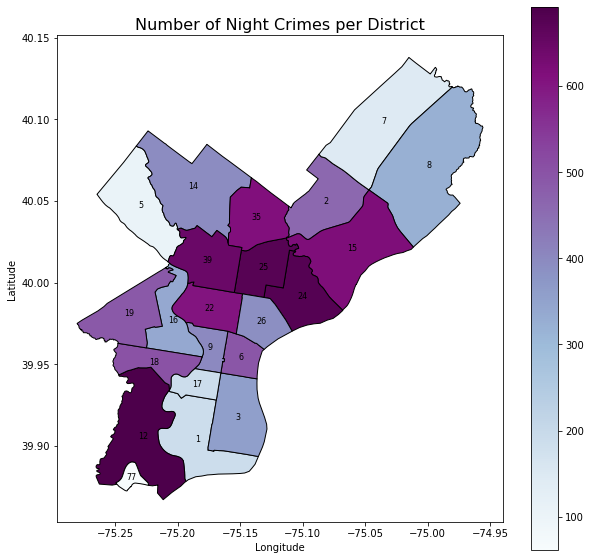

In [47]:
# heat map of all crimes

fig, ax = plt.subplots(figsize=(10,10))
district_crime_gdf.plot(column='all_night_crimes', cmap='BuPu', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of Night Crimes per District', fontsize=16)
districts_gdf.apply(show_district_nums, axis=1)

In [48]:
# why are there empty spots...
# update 4/22, FIXED IT!!!
district_crime_gdf[district_crime_gdf['DIST_NUM']==35]


,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_night_crimes
19,346,None,51597.051603,35,None,35,None,35,N. Broad St. & Champlost St.,686-3350,NWPD,1.544309e+08,2.450685e+07,20554.869138,"POLYGON ((-75.13011 40.05789, -75.12898 40.057...",-75.137001,40.039976,613


#### scaling crime and pole count by size of region/district?

* Think about how you might scale these data by the size of the region - you can get that from the geometry in the geodataframe

## <font color="magenta"> Correlation for our Conclusion </font> 

Finally, for the point of our research project, we want to correlate whether the presence of street lights helps decrease the amount of crime in a district. 
- To do so, we will correlate the data in a combined table and graph. 

## <font color="magenta"> Question: Is the amount of light correlated with the amount of crimes in PPD districts? </font> 

### <font color="magenta"> Key columns

* The pole count field will help count the number of poles per district. 
* The night crimes field will count the number of crimes at night per district. 
* The district field will help us divide data into regions. 

### <font color="magenta"> Steps

1. Inspect the data, fixing any inconsistencies, duplicated, etc. 
2. Sort districts by ascending order 
3. Select the pole counts and night crimes
4. Calculate the correlation between pole counts and night crimes using `.corr()`

In [49]:
# finding correlation between crime and light in their respective districts
# output may be screwed up by the lack of crime data for several districts
# Aggregate the number of street poles per district

# Merge the two dataframes on the 'DISTRICT_' column
combined_df = pd.merge(pole_counts, night_crime_counts, on='district')
combined_df

,district,pole_count,all_night_crimes
0,1.0,5137,189
1,2.0,9712,461
2,3.0,11447,357
3,5.0,6128,106
4,6.0,6542,494
5,7.0,10447,147
6,8.0,10414,324
7,9.0,6335,401
8,12.0,10248,692
9,14.0,14640,394


In [50]:
combined_df[['pole_count', 'all_night_crimes']].corr()

,pole_count,all_night_crimes
pole_count,1.00000,0.53178
all_night_crimes,0.53178,1.00000


**General Rule:** A decent correlation coefficient value ranges from 0.5 to 0.7, with values closer to 1 indicating a stronger positive correlation between the two variables. However, the significance of the correlation also depends on the context and the specific problem being analyzed.



**Our Conclusion:** From the correlation table, we can see that there is about a .478 correlation between the amount of street poles and the number of crimes at night. This correlation implies that the amount of street lights does affect the number of crimes. From our heatmaps and tables, where there are more street lamps there appears to be less overall crime. Thus, it is most likely a negative correlation between light and crime, as we hypothesized.

# <font color="cyan"> Further Analysis </font> 

Here, we will use filters in order to zoom in on different types of crime in correlation with light. We are still testing the same hypothesis of whether or not light affects crime, but this time we are splitting crime into severe crimes and petty crimes. 

## <font color="darkcyan"> Question: Is the amount of light correlated with the amount of severe crimes in PPD districts? What about with the petty crimes? Is there any difference between the amount of correlation? </font>

### <font color="darkcyan"> Key columns </font>

* The pole count field will help count the number of poles per district. 
* The night crimes field will count the number of crimes at night per district. 
* The district field will help us divide data into regions. 

### <font color="darkcyan"> Steps </font>

1. Inspect the data, fixing any inconsistencies, duplicated, etc. 
2. Filter by severe crimes vs. petty crimes by using the unique column names to organize the data into groups.
3. Sort districts by ascending order 
4. Select the pole counts and night crimes
5. Calculate the correlation between pole counts and night crimes using `.corr()`

## <font color="darkcyan"> Severe Crime Heat Map </font> 

- Following the same steps as the previous crime heatmap, but this time filtering for severe crimes

In [51]:
# creating a list of specific values
severe_crime = ['Aggravated Assault No Firearm', 'Aggravated Assault Firearm', 'Rape', 
                'Other Sex Offenses (Not Commercialized)', 'Arson', 'Offenses Against Family and Children']

# filter using above
severe_df = night_crime_df[night_crime_df['text_general_code'].isin(severe_crime)]
severe_df

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,...,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,Sunrise,Sunset,Daylength
45,0101000020E6100000221C0EA63CCB52C09F4FAA9EC8FD...,1392087,0101000020110F0000D2FEC5BA5EEC5FC17999DB9A708D...,1408478,22,2,2022-08-23 00:55:00+00,2022-08-22,2023-05-07 20:55:00,NaN,...,2500 BLOCK RIDGE AV,400,Aggravated Assault Firearm,-75.175577,39.982685,39.982685,-75.175577,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
115,0101000020E6100000D8DC6ED5F7C652C00B63EA32A500...,626605,0101000020110F0000287734791EE55FC1A9B1D4BA9C90...,642308,24,1,2022-10-07 07:10:00+00,2022-10-07,2023-05-07 03:10:00,NaN,...,1000 BLOCK E ERIE AV,400,Aggravated Assault No Firearm,-75.108877,40.005041,40.005041,-75.108877,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s
117,0101000020E610000073FDD4DB13C752C0C07C2E2A94FD...,629265,0101000020110F000059BBA4134EE55FC1656BE076368D...,641549,24,3,2022-10-08 01:58:00+00,2022-10-07,2023-05-07 21:58:00,NaN,...,2900 BLOCK E THOMPSON ST,400,Aggravated Assault No Firearm,-75.110587,39.981084,39.981084,-75.110587,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s
132,0101000020E610000075ADBD4F15C952C01883A0060001...,1392524,0101000020110F0000F18D593AB6E85FC1E2E107700191...,1408932,25,4,2022-10-08 01:51:00+00,2022-10-07,2023-05-07 21:51:00,NaN,...,800 BLOCK W Erie Ave,400,Aggravated Assault No Firearm,-75.141926,40.007813,40.007813,-75.141926,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s
178,0101000020E610000050427E709DCB52C004BBCC76A605...,211128,0101000020110F0000D3A4712303ED5FC1B1892BC22996...,221611,14,3,2022-08-17 09:07:00+00,2022-08-17,2023-05-07 05:07:00,NaN,...,0 BLOCK W POMONA ST,400,Aggravated Assault Firearm,-75.181484,40.044143,40.044143,-75.181484,2023-05-07 06:15:09,2023-05-07 19:53:57,13h 38m 48s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30523,0101000020E6100000FA1BDDD690C852C0D2B8A25AE5FF...,2853498,0101000020110F00007F4EEA35D5E75FC190283407C88F...,2866521,25,3,2022-04-18 04:44:00+00,2022-04-18,2023-05-07 00:44:00,0.0,...,3200 BLOCK N PHILIP ST,400,Aggravated Assault No Firearm,-75.133840,39.999187,39.999187,-75.133840,2023-05-07 06:16:57,2023-05-07 19:42:40,13h 25m 43s
30600,0101000020E610000060D8EDF5A6CF52C0D5C2B85D60FC...,2845381,0101000020110F0000BD20A3ADDEF35FC11F70C954E18B...,2856841,19,2,2022-07-08 04:12:00+00,2022-07-08,2023-05-07 00:12:00,0.0,...,500 BLOCK N 63RD ST,400,Aggravated Assault Firearm,-75.244565,39.971691,39.971691,-75.244565,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s
30622,0101000020E61000008B8B404818CA52C05BC078C470F6...,2850357,0101000020110F00003D3AA51D6EEA5FC196F7DDD84D85...,2863387,3,3,2022-07-09 01:26:00+00,2022-07-08,2023-05-07 21:26:00,21.0,...,700 BLOCK MIFFLIN ST,400,Aggravated Assault No Firearm,-75.157732,39.925316,39.925316,-75.157732,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s
30624,0101000020E610000030577170CACB52C03200D8A987FE...,2850644,0101000020110F000049C93C934FED5FC1BBC6F95D448E...,2860883,22,2,2022-07-09 02:23:00+00,2022-07-08,2023-05-07 22:23:00,22.0,...,3100 BLOCK DIAMOND ST,400,Aggravated Assault Firearm,-75.184231,39.988515,39.988515,-75.184231,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s


In [52]:
severe_counts = severe_df.groupby('district')['objectid'].count().to_frame(name='all_severe').reset_index()
severe_counts

,district,all_severe
0,1,16
1,2,45
2,3,26
3,5,14
4,6,57
5,7,6
6,8,25
7,9,24
8,12,65
9,14,37


In [53]:
dist_sev_gdf = districts_gdf.merge(severe_counts, on='district', how='right')
dist_sev_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_severe
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,16
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,45
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,26


### <font color="darkcyan"> Severe Crime Heat Map Analysis <font/> 

**Observations**: 
- Districts 24, 25 and 35 have the most amount of severe crimes, all around 100 count from the taken observations
- The severe crimes appear to be clustered around district 25

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

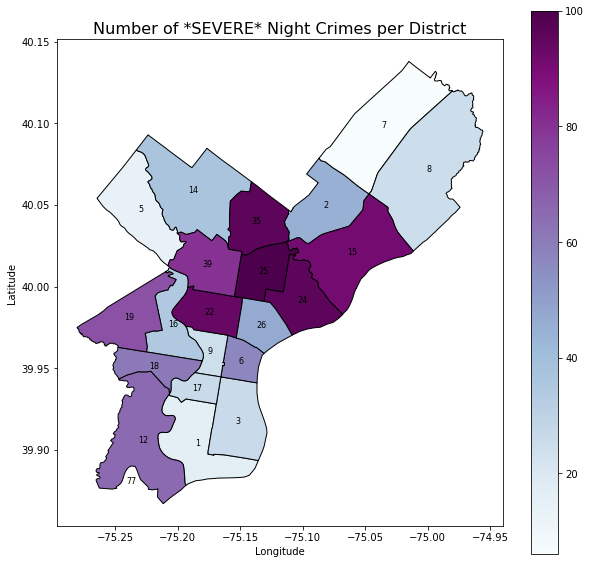

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
dist_sev_gdf.plot(column='all_severe', cmap='BuPu', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of *SEVERE* Night Crimes per District', fontsize=16)
districts_gdf.apply(show_district_nums, axis=1)

## <font color="darkcyan"> Petty Crime Heat Map <font/>

- Following the same steps as the previous crime heatmap, but this time filtering for petty crime

In [55]:
# creating a list of specific values
petty_crime = ['Thefts', 'Theft from Vehicle', 'Robbery No Firearm', 'Burglary Non-Residential', 
               'Vandalism/Criminal Mischief', 'Disorderly Conduct', 'DRIVING UNDER THE INFLUENCE', 
               'Prostitution and Commercialized Vice', 'Public Drunkenness', 'Liquor Law Violations', 
               'Gambling Violations']

# filter using above
petty_df = night_crime_df[night_crime_df['text_general_code'].isin(petty_crime)]
petty_df

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,...,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,Sunrise,Sunset,Daylength
13,NaN,626044,NaN,640253,25,1,2022-08-22 04:41:00+00,2022-08-22,2023-05-07 00:41:00,NaN,...,900 BLOCK W Lycomng St,600,Theft from Vehicle,NaN,NaN,NaN,NaN,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
28,0101000020E6100000DA9CB5A103D152C066864B962CFD...,860974,0101000020110F0000B2305BEE2EF65FC12C0DFDA9C38C...,857698,19,1,2022-08-23 01:17:00+00,2022-08-22,2023-05-07 21:17:00,NaN,...,7300 BLOCK BRENTWOOD RD,600,Thefts,-75.265847,39.977923,39.977923,-75.265847,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
54,0101000020E6100000287F39ABACC952C0FB5370994FF9...,1583214,0101000020110F00007295D952B7E95FC134AC5CC97B88...,1596606,6,3,2022-08-22 09:19:00+00,2022-08-22,2023-05-07 05:19:00,NaN,...,600 BLOCK WALNUT ST,1400,Vandalism/Criminal Mischief,-75.151164,39.947742,39.947742,-75.151164,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
95,0101000020E610000095E4CAEA67C852C0C27195FE1003...,2865261,0101000020110F0000B31341B38FE75FC1841551084C93...,2841900,25,2,2022-08-22 09:40:00+00,2022-08-22,2023-05-07 05:40:00,NaN,...,N 4TH ST & W ROOSEVELT BLVD,600,Theft from Vehicle,-75.131343,40.023956,40.023956,-75.131343,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
101,0101000020E61000005D68953628C952C025736E0B7DF6...,211194,0101000020110F0000DD6E9C55D6E85FC194349E715B85...,222953,3,2,2022-10-07 10:59:00+00,2022-10-07,2023-05-07 06:59:00,NaN,...,1600 BLOCK S CHRISTOPHER COLUMBUS BLVD,600,Thefts,-75.143079,39.925691,39.925691,-75.143079,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30617,0101000020E6100000F9D2C202EBCB52C07CA5C1A798F5...,2849052,0101000020110F0000F7CBB5E686ED5FC1C30738855E84...,2862880,1,2,2022-07-09 01:24:00+00,2022-07-08,2023-05-07 21:24:00,21.0,...,2300 BLOCK OREGON AV,600,Thefts,-75.186219,39.918721,39.918721,-75.186219,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s
30639,0101000020E61000004768D32A9DC952C03093F2A49601...,2852920,0101000020110F0000411120FE9CE95FC1337B4F73A891...,2863973,25,1,2022-07-08 04:20:00+00,2022-07-08,2023-05-07 00:20:00,0.0,...,3900 BLOCK N BROAD ST,600,Thefts,-75.150218,40.012410,40.012410,-75.150218,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s
30703,0101000020E61000000ABB076CB7C852C0ECD695434902...,2878788,0101000020110F00009AC646BF16E85FC18CC6E3866E92...,2891243,25,1,2022-07-09 03:42:00+00,2022-07-08,2023-05-07 23:42:00,23.0,...,4300 BLOCK N FAIRHILL ST,1400,Vandalism/Criminal Mischief,-75.136195,40.017861,40.017861,-75.136195,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s
30711,0101000020E6100000A5E9FD9048C352C06ADB9334BD02...,2880550,0101000020110F0000FC8C2B3DDCDE5FC1EA26291BEF92...,2879620,15,2,2022-07-09 03:53:00+00,2022-07-08,2023-05-07 23:53:00,23.0,...,6400 BLOCK TORRESDALE AV,600,Thefts,-75.051304,40.021399,40.021399,-75.051304,2023-05-07 05:40:17,2023-05-07 20:31:31,14h 51m 14s


* evidently more cells, more petty crime

In [56]:
petty_counts = petty_df.groupby('district')['objectid'].count().to_frame(name='all_petty').reset_index()
petty_counts

,district,all_petty
0,1,126
1,2,216
2,3,239
3,5,56
4,6,255
5,7,96
6,8,181
7,9,225
8,12,183
9,14,136


In [57]:
dist_pet_gdf = districts_gdf.merge(petty_counts, on='district', how='right')
dist_pet_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_petty
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,126
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,216
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,239


### <font color="darkcyan"> Petty Crime Heat Map Analysis <font/> 

**Observations**: 
- District 24 has the most amount of petty crimes, at a count of 334 crimes from the taken observations
- The most amount of petty crimes appear to be clustered around district 24
- This area of petty crimes is slightly shifted in its most occurring state as compared to the previous map

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

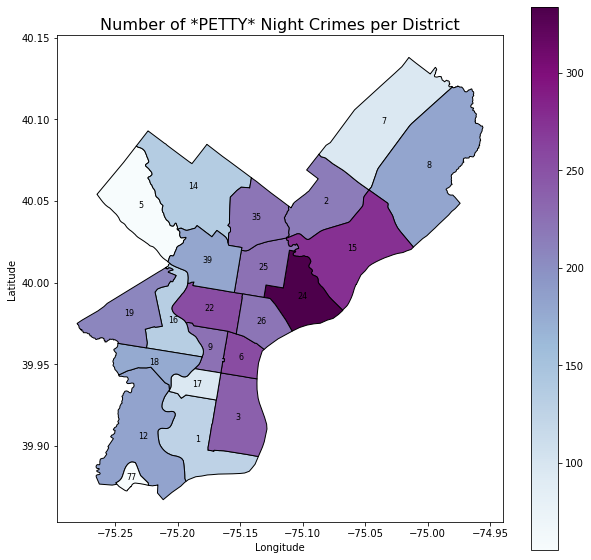

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
dist_pet_gdf.plot(column='all_petty', cmap='BuPu', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of *PETTY* Night Crimes per District', fontsize=16)
districts_gdf.apply(show_district_nums, axis=1)

## <font color="darkcyan"> Final Correlation Matrices for 'Severe' and 'Petty' Crime <font/>

**Our Conclusion:** 
From the petty crime correlation table, we can see that there is about a .43 correlation between the amount of street poles and the number of petty crimes at night. This correlation implies that the amount of street lights does affect the number of petty crimes. 

However, the severe crime correlation tableillustrates only a .29 correlation between the amount of street poles and the number of severe crimes at night. This weak correlation implies that the amount of street lights does not affect the number of severe crimes as much as it does the petty crimes. 

In [59]:
# severe vs. poles 
severe_corr_df = pd.merge(pole_counts, severe_counts, on='district')
severe_corr_df

,district,pole_count,all_severe
0,1.0,5137,16
1,2.0,9712,45
2,3.0,11447,26
3,5.0,6128,14
4,6.0,6542,57
5,7.0,10447,6
6,8.0,10414,25
7,9.0,6335,24
8,12.0,10248,65
9,14.0,14640,37


In [60]:
severe_corr_df[['pole_count', 'all_severe']].corr()

,pole_count,all_severe
pole_count,1.000000,0.359672
all_severe,0.359672,1.000000


In [61]:
# petty vs. poles 
petty_corr_df = pd.merge(pole_counts, petty_counts, on='district')
petty_corr_df

,district,pole_count,all_petty
0,1.0,5137,126
1,2.0,9712,216
2,3.0,11447,239
3,5.0,6128,56
4,6.0,6542,255
5,7.0,10447,96
6,8.0,10414,181
7,9.0,6335,225
8,12.0,10248,183
9,14.0,14640,136


In [62]:
petty_corr_df[['pole_count', 'all_petty']].corr()

,pole_count,all_petty
pole_count,1.000000,0.495356
all_petty,0.495356,1.000000


## <font color="BlueViolet"> Question: What if we regarded our data with higher granularity? If we were to repeat our process with neighborhoods instead of districts, could we gain more conclusive findings? Is there a correlation between street lights and crime in neighborhoods? </font>

## <font color="BlueViolet"> Neighborhood analysis </font>

**Reasoning**: 
In retrospect, we should've done this project with neighborhoods instead of police districts. The rationale behind choosing police districts was simple: familiarity. We had already used it earlier in the class in prior notebooks during class so it felt natural to extend that. Districts were a strong start, but we would like to go into deeper analysis by focusing on neighborhoods. 

In [63]:
neighborhood_gdf = gpd.read_file('../data/gn-philadelphia.geojson')

### <font color="BlueViolet"> Steps </font>

* Use the neighborhood geo data frame (gdf) and plot the neighborhood divisions. 
* Inspect the gdf to get a general sense of the columns
* Utilize these map divisions to map where street lights and crime are most present, utilzing same methods as the above mapping on districts.

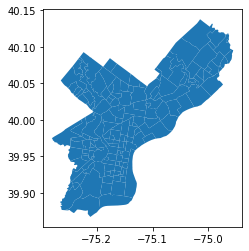

In [64]:
neighborhood_gdf.plot()
plt.show()

## <font color="BlueViolet"> Inspect the Neighborhood Data </font>

### <font color="BlueViolet"> What does our below data inspection show us? </font>
    
* We can see the neighborhood data is separated into multiple columns, most importantly `geometry`, which we can use to graph where the neighborhoods are on the map of Philly
* The `simple_n_gdf` will help us narrow down the columns to neighborhood name and geometry, simplifying the data for further use 
* For the fun part, we can join the street pole and neighborhood data to be able to plot where the lights are within each neighborhood.
    - This will be especially helpful for out upcoming heatmaps. 
    - Now, we can view a simple table which states the neighborhood name and the street pole count per neighborhood. 

In [65]:
neighborhood_gdf.head(3)

,fclass,name,countryCode,geonameid,created_at,cartodb_id,updated_at,fcode,lat,parents,adminCode4,lng,adminCode1,adminCode2,adminCode3,geometry
0,P,Pennypack Park,US,5205602,2013-03-19T16:41:50.507999+00:00,1,2013-03-19T16:41:50.743000+00:00,PPLX,40.069786,4560349,,-75.048898,PA,101,,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ..."
1,P,Overbrook,US,4560179,2013-03-19T16:41:50.507999+00:00,2,2013-03-19T16:41:50.743000+00:00,PPLX,39.978660,4560349,,-75.253486,PA,101,,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ..."
2,P,Southwest Germantown,US,None,2013-03-19T16:41:50.507999+00:00,3,2013-03-19T16:41:50.743000+00:00,PPLX,40.023592,4560349,,-75.167375,PA,101,,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ..."


In [66]:
simple_n_gdf = neighborhood_gdf[['name','geometry']]
simple_n_gdf

,name,geometry
0,Pennypack Park,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ..."
1,Overbrook,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ..."
2,Southwest Germantown,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ..."
3,East Parkside,"MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ..."
4,Germany Hill,"MULTIPOLYGON (((-75.22722 40.03523, -75.22865 ..."
...,...,...
153,Navy Yard,"MULTIPOLYGON (((-75.17343 39.89710, -75.17096 ..."
154,East Kensington,"MULTIPOLYGON (((-75.12025 39.98476, -75.12154 ..."
155,Elmwood,"MULTIPOLYGON (((-75.21769 39.92732, -75.22628 ..."
156,Girard Estates,"MULTIPOLYGON (((-75.18694 39.92232, -75.18344 ..."


In [67]:
simple_n_gdf.dtypes

name          object
geometry    geometry
dtype: object

In [68]:
simple_sp_gdf

,OBJECTID,geometry
0,1,POINT (-75.06641 40.04477)
1,2,POINT (-75.06118 40.04186)
2,3,POINT (-75.14445 40.00828)
3,4,POINT (-75.14429 40.00823)
4,5,POINT (-75.26081 39.87661)
...,...,...
195675,195676,POINT (-75.21628 39.96402)
195676,195677,POINT (-75.14097 40.01589)
195677,195678,POINT (-75.13393 39.96448)
195678,195679,POINT (-75.14838 39.97740)


In [69]:
simple_sp_gdf.dtypes

OBJECTID       int64
geometry    geometry
dtype: object

In [70]:
# join gdfs, with the streetpole geometry identifying which neighborhood it would be in
spn_gdf = gpd.sjoin(simple_sp_gdf, simple_n_gdf, op='within')
spn_gdf.head(3)

,OBJECTID,geometry,index_right,name
0,1,POINT (-75.06641 40.04477),67,Oxford Circle
1,2,POINT (-75.06118 40.04186),67,Oxford Circle
130492,130493,POINT (-75.08773 40.03598),67,Oxford Circle


In [71]:
sp_neighborhood_counts = spn_gdf.groupby('name').size().reset_index(name='streetpole_count')
sp_neighborhood_counts

,name,streetpole_count
0,Academy Gardens,518
1,Airport,356
2,Allegheny West,2227
3,Andorra,531
4,Aston-Woodbridge,420
...,...,...
153,Wister,559
154,Woodland Terrace,113
155,Wynnefield,1560
156,Wynnefield Heights,338


In [72]:
sp_counts_n_gdf = simple_n_gdf.merge(sp_neighborhood_counts, on='name')
sp_counts_n_gdf.head(3)

,name,geometry,streetpole_count
0,Pennypack Park,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ...",341
1,Overbrook,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ...",3743
2,Southwest Germantown,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ...",925


## <font color="BlueViolet"> Street Poles in Neighborhoods Heatmap </font>
### <font color="BlueViolet"> Steps </font>
- Plot the poles and neighborhoods into a heatmap using the `.plot()` function 
With the now joined data, we can create a heatmap to best illustrate the amount of street poles per neighborhood. 
- Interestingly, plotting the raw number of street poles per neighborhood does not seem to reveal many specific regions of interest. Perhaps there is a better way of mapping, including by density instead of count.  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


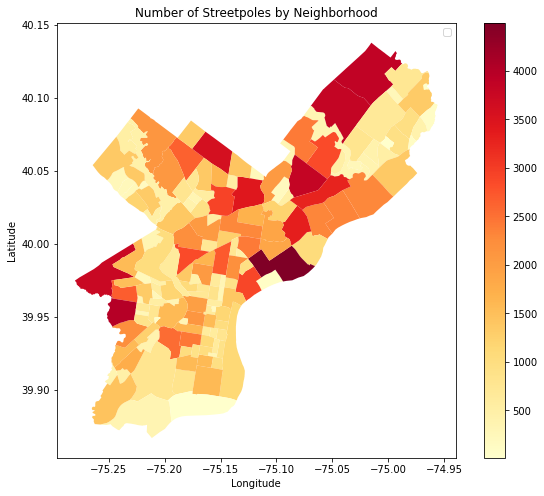

In [73]:
# plot the GeoDataFrame as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sp_counts_n_gdf.plot(column='streetpole_count', cmap='YlOrRd', legend=True, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of Streetpoles by Neighborhood')
plt.legend()
plt.show()

## <font color="DarkSalmon"> Time to look at Severe Crime and Neighborhoods </font>
### <font color="DarkSalmon"> Steps </font>
- First, let's do the same steps as previously done and inspect the severe crime data. 
    - We can note there are 23,373 observations, but some crimes are not reported and this data does not necessarily capture the entirety of crime. However, it is still a good basepoint for further analysis. 
- Next, we must merge the datasets to once again help create the heatmaps which will visualize crime on a map divided by neighborhoods. 

In [74]:
severe_df.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,...,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,Sunrise,Sunset,Daylength
45,0101000020E6100000221C0EA63CCB52C09F4FAA9EC8FD...,1392087,0101000020110F0000D2FEC5BA5EEC5FC17999DB9A708D...,1408478,22,2,2022-08-23 00:55:00+00,2022-08-22,2023-05-07 20:55:00,NaN,...,2500 BLOCK RIDGE AV,400,Aggravated Assault Firearm,-75.175577,39.982685,39.982685,-75.175577,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
115,0101000020E6100000D8DC6ED5F7C652C00B63EA32A500...,626605,0101000020110F0000287734791EE55FC1A9B1D4BA9C90...,642308,24,1,2022-10-07 07:10:00+00,2022-10-07,2023-05-07 03:10:00,NaN,...,1000 BLOCK E ERIE AV,400,Aggravated Assault No Firearm,-75.108877,40.005041,40.005041,-75.108877,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s
117,0101000020E610000073FDD4DB13C752C0C07C2E2A94FD...,629265,0101000020110F000059BBA4134EE55FC1656BE076368D...,641549,24,3,2022-10-08 01:58:00+00,2022-10-07,2023-05-07 21:58:00,NaN,...,2900 BLOCK E THOMPSON ST,400,Aggravated Assault No Firearm,-75.110587,39.981084,39.981084,-75.110587,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s


In [75]:
severe_df.size

23373

In [76]:
# create a new GeoDataFrame from the crime DataFrame that uses the lng and lat to obtain a point where the crime occurred 
s_crime_gdf = gpd.GeoDataFrame(severe_df, geometry=gpd.points_from_xy(severe_df.lng, severe_df.lat))
s_crime_gdf.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,...,ucr_general,text_general_code,point_x,point_y,lat,lng,Sunrise,Sunset,Daylength,geometry
45,0101000020E6100000221C0EA63CCB52C09F4FAA9EC8FD...,1392087,0101000020110F0000D2FEC5BA5EEC5FC17999DB9A708D...,1408478,22,2,2022-08-23 00:55:00+00,2022-08-22,2023-05-07 20:55:00,NaN,...,400,Aggravated Assault Firearm,-75.175577,39.982685,39.982685,-75.175577,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s,POINT (-75.17558 39.98268)
115,0101000020E6100000D8DC6ED5F7C652C00B63EA32A500...,626605,0101000020110F0000287734791EE55FC1A9B1D4BA9C90...,642308,24,1,2022-10-07 07:10:00+00,2022-10-07,2023-05-07 03:10:00,NaN,...,400,Aggravated Assault No Firearm,-75.108877,40.005041,40.005041,-75.108877,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s,POINT (-75.10888 40.00504)
117,0101000020E610000073FDD4DB13C752C0C07C2E2A94FD...,629265,0101000020110F000059BBA4134EE55FC1656BE076368D...,641549,24,3,2022-10-08 01:58:00+00,2022-10-07,2023-05-07 21:58:00,NaN,...,400,Aggravated Assault No Firearm,-75.110587,39.981084,39.981084,-75.110587,2023-05-07 07:03:45,2023-05-07 18:32:43,11h 28m 58s,POINT (-75.11059 39.98108)


#### <font color="DarkSalmon"> Quick `.describe` </font>
- We can perform a spatial join to merge crimes to neighborhoods.
- We can then count the number of crimes in each.
    - Below, the max severe crime count in a neighborhood appears to be 44.
    - The minimum sever crime count is 1, so the range is notable.

In [77]:
# perform a spatial join to join the crimes to the neighborhoods
s_crimen_gdf = gpd.sjoin(s_crime_gdf, simple_n_gdf, op='within')
# group the joined GeoDataFrame by neighborhood and count the number of crimes in each
s_neighborhood_counts = s_crimen_gdf.groupby('name').size().reset_index(name='crime_count')

s_neighborhood_counts.describe()

,crime_count
count,135.000000
mean,7.814815
std,8.921871
min,1.000000
25%,2.000000
50%,5.000000
75%,9.500000
max,44.000000


In [78]:
# merge the neighborhood counts with the original neighborhood GeoDataFrame
s_crime_n_gdf = simple_n_gdf.merge(s_neighborhood_counts, on='name')
s_crime_n_gdf.head(3)

,name,geometry,crime_count
0,Overbrook,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ...",13
1,Southwest Germantown,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ...",8
2,East Parkside,"MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ...",5


## <font color="DarkSalmon"> Severe Crimes by Neighborhood Heatmap </font>
- The following heatmap uses the `.plot()` function to plot severe crimes by count onto the neighborhood divisions of Philly
- Areas in central Philadelphia appear to be of interest, which we will be able to zoom into later in the notebook. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


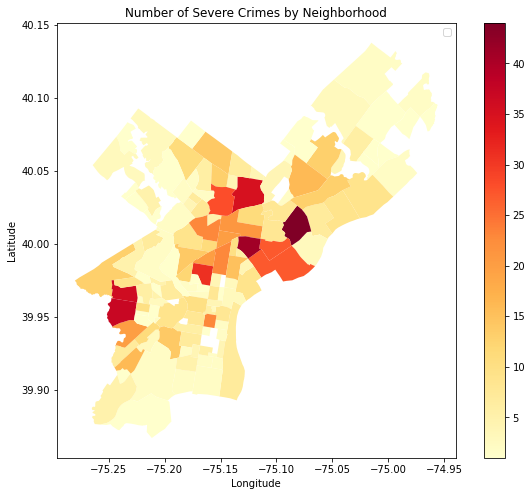

In [101]:
# plot the resulting GeoDataFrame as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))
s_crime_n_gdf.plot(column='crime_count', cmap='YlOrRd', legend=True, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of Severe Crimes by Neighborhood')
plt.legend()
plt.show()

## <font color="DarkSalmon"> What about Petty Crimes by Neighborhood? </font>
- We can follow the same steps we did just above in order to plot petty crimes onto the neighborhood divided map. 
- In the following inspection, we can note that there is a higher amount of petty crimes compared to severe crimes, and the max count of petty crimes in a neighborhood is 97 as opposed to the max of 44 severe crimes. This fact makes sense as petty crimes like theft are more common than severe crimes like murder. 

In [80]:
petty_df.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,...,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng,Sunrise,Sunset,Daylength
13,NaN,626044,NaN,640253,25,1,2022-08-22 04:41:00+00,2022-08-22,2023-05-07 00:41:00,NaN,...,900 BLOCK W Lycomng St,600,Theft from Vehicle,NaN,NaN,NaN,NaN,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
28,0101000020E6100000DA9CB5A103D152C066864B962CFD...,860974,0101000020110F0000B2305BEE2EF65FC12C0DFDA9C38C...,857698,19,1,2022-08-23 01:17:00+00,2022-08-22,2023-05-07 21:17:00,NaN,...,7300 BLOCK BRENTWOOD RD,600,Thefts,-75.265847,39.977923,39.977923,-75.265847,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s
54,0101000020E6100000287F39ABACC952C0FB5370994FF9...,1583214,0101000020110F00007295D952B7E95FC134AC5CC97B88...,1596606,6,3,2022-08-22 09:19:00+00,2022-08-22,2023-05-07 05:19:00,NaN,...,600 BLOCK WALNUT ST,1400,Vandalism/Criminal Mischief,-75.151164,39.947742,39.947742,-75.151164,2023-05-07 06:19:54,2023-05-07 19:46:46,13h 26m 52s


In [81]:
petty_df.size

85911

In [82]:
petty_df=petty_df.dropna()

In [83]:
petty_df.size

68670

In [84]:
# create a new GeoDataFrame from the crime DataFrame that uses the lng and lat to obtain a point where the crime occurred 
p_crime_gdf = gpd.GeoDataFrame(petty_df, geometry=gpd.points_from_xy(petty_df.lng, petty_df.lat))
p_crime_gdf.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,...,ucr_general,text_general_code,point_x,point_y,lat,lng,Sunrise,Sunset,Daylength,geometry
5460,0101000020E61000001874294B00C852C0DF5EA999FBFD...,2844609,0101000020110F0000D57667AFDFE65FC13037C51CA98D...,2857657,26,3,2022-08-02 01:41:00+00,2022-08-01,2023-05-07 21:41:00,21.0,...,600,Theft from Vehicle,-75.125018,39.984241,39.984241,-75.125018,2023-05-07 06:00:02,2023-05-07 20:13:52,14h 13m 50s,POINT (-75.12502 39.98424)
5471,0101000020E6100000FD3727DD33CA52C022EAF4720EFC...,2847168,0101000020110F0000C3E14BF79CEA5FC1FFD0EA8C868B...,2866563,6,1,2022-08-02 00:54:00+00,2022-08-01,2023-05-07 20:54:00,20.0,...,600,Theft from Vehicle,-75.159416,39.969191,39.969191,-75.159416,2023-05-07 06:00:02,2023-05-07 20:13:52,14h 13m 50s,POINT (-75.15942 39.96919)
5477,0101000020E610000062FB03C4E8CA52C0ED04664BF7F9...,2848111,0101000020110F00007CD1F43ED0EB5FC1B2AB78923589...,2861138,9,2,2022-08-02 01:46:00+00,2022-08-01,2023-05-07 21:46:00,21.0,...,600,Thefts,-75.170457,39.952859,39.952859,-75.170457,2023-05-07 06:00:02,2023-05-07 20:13:52,14h 13m 50s,POINT (-75.17046 39.95286)


#### <font color="DarkSalmon"> Quick `.describe` </font>
- We can perform a spatial join to merge petty crimes to neighborhoods.
- We can then count the number of crimes in each.
    - Below, the max severe crime count in a neighborhood appears to be 97.
    - The minimum sever crime count is 1, so the range is notable.

In [85]:
# perform a spatial join to join the crimes to the neighborhoods
p_crime_n_gdf = gpd.sjoin(p_crime_gdf, simple_n_gdf, op='within')
# group the joined GeoDataFrame by neighborhood and count the number of crimes in each
p_neighborhood_counts = p_crime_n_gdf.groupby('name').size().reset_index(name='crime_count')

p_neighborhood_counts.describe()

,crime_count
count,149.000000
mean,21.946309
std,21.696240
min,1.000000
25%,6.000000
50%,14.000000
75%,28.000000
max,97.000000


In [86]:
# merge the neighborhood counts with the original neighborhood GeoDataFrame
p_crime_n_gdf2 = simple_n_gdf.merge(p_neighborhood_counts, on='name')
p_crime_n_gdf2.head(3)

,name,geometry,crime_count
0,Pennypack Park,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ...",1
1,Overbrook,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ...",38
2,Southwest Germantown,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ...",14


## <font color="DarkSalmon"> Petty Crimes by Neighborhood Heatmap </font>
- The following heatmap uses the `.plot()` function to plot petty crimes by count onto the neighborhood divisions of Philly
- Areas in the center-right of the map appear to be of interest, which we will be able to zoom into later in the notebook. 
    - The districts with the highest severe crime counts are similar to the districts with highest petty crime counts, though not exactly the same. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


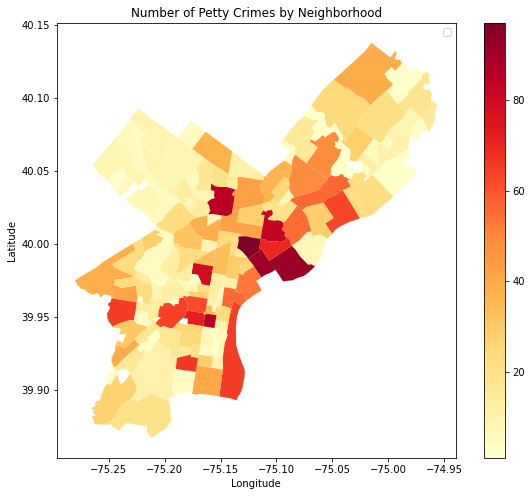

In [87]:
# plot the resulting GeoDataFrame as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))
p_crime_n_gdf2.plot(column='crime_count', cmap='YlOrRd', legend=True, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of Petty Crimes by Neighborhood')
plt.legend()
plt.show()

## <font color="DarkSeaGreen"> Question: Which neighborhoods are of most interest regarding crime? What does their street pole output look like? </font>
- Let's zoom into specific neighborhoods.
    - First, let's find the neighborhoods with the most amount of severe crime incidents and petty crime incidents
        - We can see that Frankford has the highest severe crime count of 44 severe crimes. 
        - We can also see that Upper Kensington has the highest petty crime count at 97 petty crimes.

In [88]:
s_crime_n_gdf.sort_values('crime_count', ascending=False).head(1)

,name,geometry,crime_count
30,Frankford,"MULTIPOLYGON (((-75.06885 40.00859, -75.06887 ...",44


In [89]:
p_crime_n_gdf2.sort_values('crime_count', ascending=False).head(1)

,name,geometry,crime_count
95,Upper Kensington,"MULTIPOLYGON (((-75.12785 40.00532, -75.12397 ...",97


## <font color="DarkSeaGreen"> Zooming into Frankford and Upper Kensington </font>

- Alright, time to look deeper into Frankford and Upper Kensington

### <font color="DarkSeaGreen"> Steps </font>
1. First, we filter the data by neighborhood, in this case we will start with the `frankford_gdf` filter
2. Then, we clean the data to make it easier to work with.
3. We can filter the street pole data to only include points within Frankford. 
4. We can double check ourselves to note that there are 3,327 street poles and 44 severe crimes in the neighborhood of Frankford. 
5. Finally, we can create a map to visualize our data.

In [90]:
# filtering for neighborhood
frankford_gdf = simple_n_gdf[simple_n_gdf['name'] == 'Frankford']
uk_gdf = simple_n_gdf[simple_n_gdf['name'] == 'Upper Kensington']

In [91]:
# cleaning data
simple_sp_gdf = street_poles_gdf[['OBJECTID', 'geometry']]
simple_sp_gdf.head(3)

,OBJECTID,geometry
0,1,POINT (-75.06641 40.04477)
1,2,POINT (-75.06118 40.04186)
2,3,POINT (-75.14445 40.00828)


In [102]:
# filter the data to only include points within the Frankford neighborhood
frankford_sp_gdf = simple_sp_gdf[simple_sp_gdf.within(frankford_gdf.geometry.iloc[0])]
frankford_severe_gdf = s_crime_gdf[s_crime_gdf.within(frankford_gdf.geometry.iloc[0])]

In [93]:
# sanity checking how many crimes and streetpoles there are in hunting park
print(frankford_sp_gdf.shape[0])
print(frankford_severe_gdf.shape[0])

3327
44


### <font color="DarkSeaGreen"> First: Frankford Map </font>
- Use the `.plot()` function to map Frankford's street pole and petty crime data.
We can map street poles and severe crimes onto a map of Franford to analyze if there could be a correlation between where the poles are and where severe crime happens. From a first glance, it is difficult to see where the blue and red dots are overlapping. We should try and make it more evident by increasing the size of the blue dots. 

**Observations**: 
- From what we can tell, the dots are relatively randomly scattered
    - In our previous correlational analysis, we noticed that street lights don't affect the amount of severe crime as much as they do petty crime. Perhaps looking at Upper Kensington will prove to have more valuable correlation. 

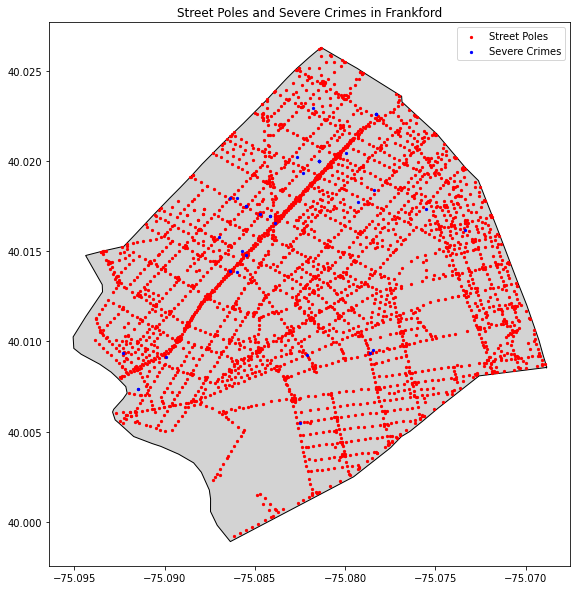

In [103]:
# create a map of Hunting Park with street poles and severe crimes
fig, ax = plt.subplots(figsize=(10, 10))
frankford_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
frankford_sp_gdf.plot(ax=ax, color='red', markersize=5, label='Street Poles')
frankford_severe_gdf.plot(ax=ax, color='blue', markersize=5, label='Severe Crimes')
ax.set_title('Street Poles and Severe Crimes in Frankford')
ax.legend()
plt.show()

### <font color="DarkSeaGreen"> Second: Upper Kensington Map </font>
- Follow the same steps as we did for Frankford. 
- Use the `.plot()` function to map Upper Kensington's street pole and petty crime data.
We can map street poles and severe crimes onto a map of Upper Kensington to analyze if there could be a correlation between where the poles are and where petty crime happens. From a first glance, it is difficult to see where the blue and red dots are overlapping. We should try and make it more evident by increasing the size of the blue dots. 

**Observations**: 
- From what we can tell, the dots may appear to be lined up on the corner of different blocks of street poles. 
    - It is relatively difficult to tell, so we will try a density map to see if that helps.

In [105]:
# filter the data to only include points within the Upper Kensington neighborhood
uk_sp_gdf = simple_sp_gdf[simple_sp_gdf.within(uk_gdf.geometry.iloc[0])]
uk_petty_gdf = p_crime_gdf[p_crime_gdf.within(uk_gdf.geometry.iloc[0])]

In [96]:
# sanity checking how many crimes and streetpoles there are in hunting park
print(uk_sp_gdf.shape[0])
print(uk_petty_gdf.shape[0])

2414
97


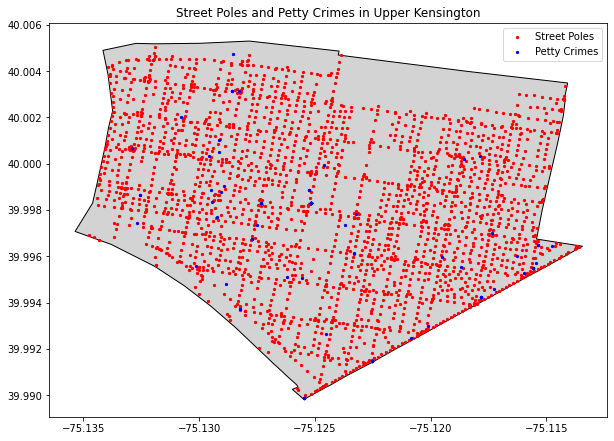

In [104]:
# create a map of Hunting Park with street poles and severe crimes
fig, ax = plt.subplots(figsize=(10, 10))
uk_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
uk_sp_gdf.plot(ax=ax, color='red', markersize=5, label='Street Poles')
uk_petty_gdf.plot(ax=ax, color='blue', markersize=5, label='Petty Crimes')
ax.set_title('Street Poles and Petty Crimes in Upper Kensington')
ax.legend()
plt.show()

### <font color="DarkSeaGreen"> First: Frankford Map Pole Density Analysis </font>
- Use the `.plot()` function to map Frankford's street pole and petty crime data.
- We wanted to try pole density analysis instead of just raw count as well

**Observations**: 
- The observations seem to be randomly scattered
- The larger blue dot helps note where the severe crimes are taking in relation to street poles -- this was a good choice on our part

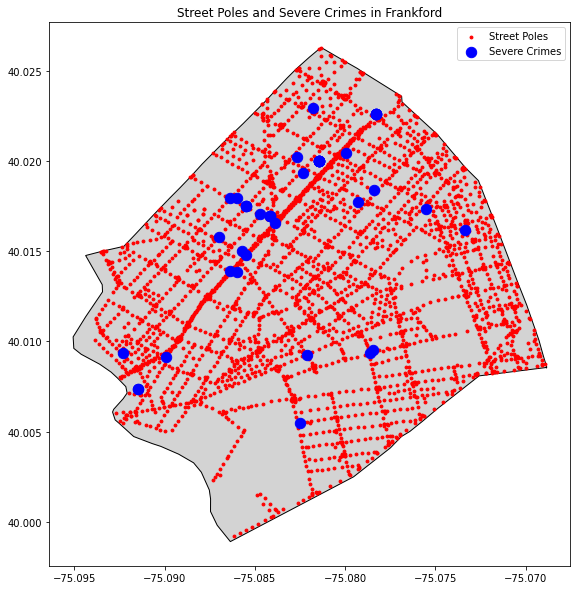

In [98]:
# calculate the density of street poles in Frankford
frankford_pole_density = len(frankford_sp_gdf) / frankford_gdf.geometry.iloc[0].area

# calculate the density of severe crimes in Frankford
frankford_crime_density = len(frankford_severe_gdf) / frankford_gdf.geometry.iloc[0].area

# normalize the counts using the area of the Frankford polygon
# frankford_pole_normalized_count = len(frankford_sp_gdf) * frankford_pole_density
# frankford_crime_normalized_count = len(frankford_severe_gdf) * frankford_crime_density

# since the above code made the graph absolutely unreadable (feel free to uncomment to see what it looks like) i had to custom make the scales
# i know it the defeats teh purpose, just not sure what else i can do
frankford_pole_normalized_count = len(frankford_sp_gdf) / frankford_gdf.geometry.iloc[0].area * .000001
frankford_crime_normalized_count = len(frankford_severe_gdf) / frankford_gdf.geometry.iloc[0].area * .001

# create a map of Frankford with street poles and severe crimes, showing normalized counts
fig, ax = plt.subplots(figsize=(10, 10))
frankford_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='Frankford')
frankford_sp_gdf.plot(ax=ax, color='red', markersize=frankford_pole_normalized_count, label='Street Poles')
frankford_severe_gdf.plot(ax=ax, color='blue', markersize=frankford_crime_normalized_count, label='Severe Crimes')
ax.set_title('Street Poles and Severe Crimes in Frankford')
ax.legend()
plt.show()

### <font color="DarkSeaGreen"> Second: Upper Kensington Map Pole Density Analysis </font>
- Use the `.plot()` function to map Frankford's street pole and petty crime data.
- We wanted to try pole density analysis instead of just raw count as well

**Observations**: 
- The observations seem to line up along lines of the street lights. 
    - It is difficult to tell exactly where these locations are and if there's much significance. 

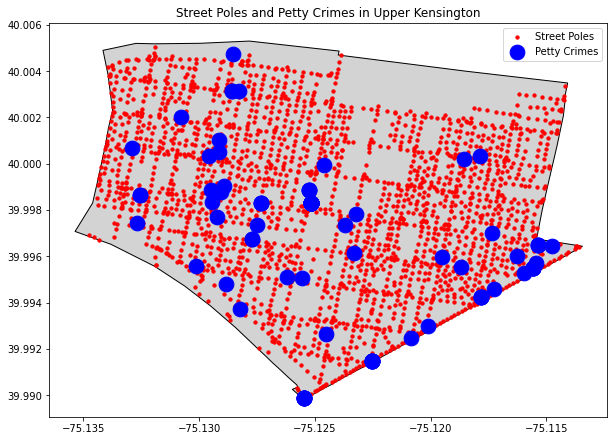

In [99]:
# calculate the density of street poles in Upper Kensington
uk_pole_density = len(uk_sp_gdf) / uk_gdf.geometry.iloc[0].area

# calculate the density of severe crimes in Upper Kensington
uk_crime_density = len(uk_petty_gdf) / uk_gdf.geometry.iloc[0].area

# normalize the counts using the area of the Upper Kensington polygon
#uk_pole_normalized_count = len(uk_sp_gdf) * uk_pole_density
#uk_crime_normalized_count = len(uk_petty_gdf) * uk_crime_density

# same case as above...
uk_pole_normalized_count = len(uk_sp_gdf) / uk_gdf.geometry.iloc[0].area * .000001
uk_crime_normalized_count = len(uk_petty_gdf) / uk_gdf.geometry.iloc[0].area * .0005

# create a map of Upper Kensington with street poles and severe crimes, showing normalized counts
fig, ax = plt.subplots(figsize=(10, 10))
uk_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='Upper Kensington')
uk_sp_gdf.plot(ax=ax, color='red', markersize=uk_pole_normalized_count, label='Street Poles')
uk_petty_gdf.plot(ax=ax, color='blue', markersize=uk_crime_normalized_count, label='Petty Crimes')
ax.set_title('Street Poles and Petty Crimes in Upper Kensington')
ax.legend()
plt.show()